<a href="https://colab.research.google.com/github/tayfununal/hamiltonian_ex/blob/main/symplectic_euler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#simplektik euler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

plt.style.use('seaborn-poster')

np.random.seed(1)
tf.random.set_seed(1)

initial_point= [0., 1.]

def symplectic_euler(h=0.05, initial_point= [0., 1.]):

    t = np.arange(0, 2*np.pi, h)

    q = np.zeros(t.shape[0])
    p = np.zeros(t.shape[0])

    q[0] = initial_point[0]
    p[0] = initial_point[1]
    
    for i in range(0, t.shape[0]-1):
      q[i + 1] = (1-h**2) * q[i] + h * p[i]
      p[i + 1] = p[i] - h * q[i]

    return q, p, t

q , p, t = symplectic_euler()
print("shape of q :", q.shape ,"\nshape of p:", p.shape, "\nsize of t:", len(t))

def grand_truth_plot(h = 0.1):
  t = np.arange(0,2*np.pi,0.3)
  q = np.sin(t)
  p = np.cos(t)
  plt.scatter(q,p)

def pred_plot(q, p):
  plt.plot(q[:, ], p[:,], c = "red")
  plt.xlabel('q', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.ylabel('p', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.title("Phase Diagram", fontsize=17,fontweight="bold",fontname="Times New Roman")

shape of q : (126,) 
shape of p: (126,) 
size of t: 126


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


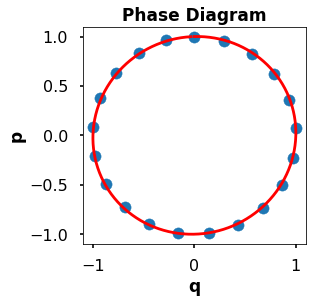

In [2]:
plt.figure(figsize = (4, 4))

# Simplectic solution plot
pred_plot(q=q, p=p)

# Grand truth solution plot
grand_truth_plot()
plt.show()

In [3]:
z = np.concatenate((q.reshape(-1,1), p.reshape(-1,1)) , axis=1)
t = t

In [4]:
target = np.concatenate((q.reshape(-1,1), p.reshape(-1,1)) , axis=1)[1:]
input_t = t[1:]

In [5]:
inp = Input(shape=(1,))

x = Dense(512, activation="relu", name="hidden_layer_1")(inp)
x = Dense(512, activation="relu", name="hidden_layer_2")(x)
x = Dense(512, activation="relu", name="hidden_layer_3")(x)
x = Dense(512, activation="relu", name="hidden_layer_4")(x)
x = Dense(2)(x)
out = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp**2)) * tf.matmul(x, tf.constant([[0., -1.],[1., 0.]]))

model = Model(inputs=inp, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 hidden_layer_1 (Dense)         (None, 512)          1024        ['input_1[0][0]']                
                                                                                                  
 hidden_layer_2 (Dense)         (None, 512)          262656      ['hidden_layer_1[0][0]']         
                                                                                                  
 tf.math.pow (TFOpLambda)       (None, 1)            0           ['input_1[0][0]']                
                                                                                              

In [6]:
# Hamiltonian Equation
def H(z):
  return tf.reduce_sum((z**2)/2,axis=1)

# loss function
def custom_loss(y_true, y_pred):

  return tf.keras.losses.MSE(y_true, y_pred) + 20 * tf.keras.losses.MSE(0.5, H(y_pred))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss=custom_loss)

model.fit(x=input_t, y=target, epochs=8000, batch_size=64)

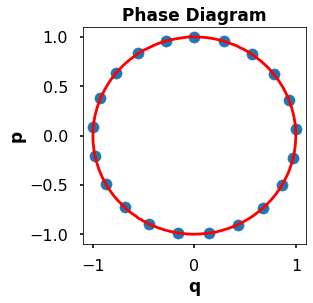

In [8]:
test_t = np.arange(0, 2*np.pi, 0.001)
prediction = model(test_t)

q = prediction[:,0]
p = prediction[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q, p )

# Grand truth solution plot
grand_truth_plot()

plt.show()

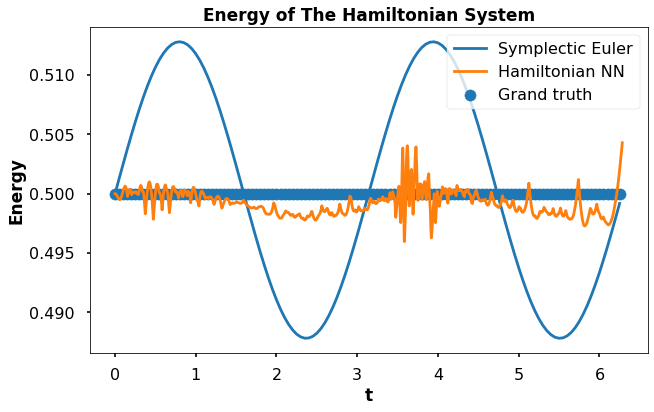

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(t, [0.5 for i in range(t.shape[0])], label="Grand truth")
plt.plot(t ,H(z), label= "Symplectic Euler")
plt.plot(test_t, H(model(test_t)), label="Hamiltonian NN")
plt.legend(loc="upper right")
plt.xlabel("t",fontsize=17,fontweight="bold",fontname="Times New Roman")
plt.ylabel("Energy",fontsize=17,fontweight="bold",fontname="Times New Roman")
plt.title("Energy of The Hamiltonian System", fontsize=17,fontweight="bold",fontname="Times New Roman")
plt.show()

In [21]:
np.set_printoptions(threshold=np.inf)

In [22]:
f = open("demofile2.txt", "a")
f.write("{}".format(H(model(test_t)).numpy()))
f.close()